In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})
print(matplotlib.pyplot.get_backend())

module://ipykernel.pylab.backend_inline


# Hello World mnist (pytorch)

支援python 版本: 3.5以上   
支援pytorch版本 : 1.2以上

這次實作要使用的是深度學習界的Hello world也就是手寫數字數據集MNIST(別誤寫為MINIST歐)。MNIST 數據集來自美國國家標準與技術研究所, National Institute of St andards and Technology (NIST). 訓練集 (training set) 由來自 250 個不同人手寫的數字構成, 其中 50% 是高中學生, 50% 來自人口普查局 (the Census Bureau) 的工作人員. 測試集(test set) 也是同樣比例的手寫數字數據。基本上這個數據集毫無挑戰性，任何神經網路幾乎都能獲得很好的擬合效果，所以它也很常被做為新算法觀念驗證使用。

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'pytorch'
import trident as T
from trident import *

trident 0.6.3
Pillow version:7.1.2.


Pytorch version:1.6.0+cu101.
Automatic Mixed Precision Support:True.
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.


在我們這次一系列實作課程改版，很大的差異就是來自於有了新的API:trident,它的概念是提供不同框架的平行開發範本，讓跨框架的開發體驗都能一致化，同時透過封裝過的API，各位也就不需要在關注那些瑣碎的事，掉坑的可能性也會少一點。首先我們來看trident很重要的一個特性，那就是可以一行指令來獲取我們的數據集，我們這次有把經典數據集，以及我為了課程所設計的數據集進行封裝，以MNIST數據集為例，各位只要如下方的一行指令就能存取數據，再加一行就能完成數據的清洗。

In [3]:
data_provider=T.load_mnist('mnist') #讀取mnist數據集
data,label=data_provider.next()
print(data)
print(data.shape,label.shape)
print(data_provider.signature)

imgs,labels=data_provider.next()
                        
merged_img=array2image(np.concatenate(imgs,axis=2)) #沿著x軸(axis=2)疊合後，利用array2image轉成圖檔

data_provider.image_transform_funcs=[normalize(127.5,127.5)] #在圖像預處理流程中加入正規化

merged_img #顯示圖片

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.
[[[[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   ...
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]]]


 [[[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]
   ...
   [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00
    0.0000e+00]

你也可以透過簡單的將數據集名稱改成'fashion-mnist'，就能夠存取到難度略高一點點的fashion mnist數據集。他們都是由28*28的黑白圖片組成(攤平後為長度784)，類別數量都是10。

In [4]:
fdata_provider=T.load_mnist('fashion-mnist') #讀取fashion mnist數據集
fimgs,flabels=fdata_provider.next()
merged_img2=array2image(np.concatenate(fimgs,axis=2)) #沿著x軸(axis=1)疊合後，利用array2image轉成圖檔
fdata_provider.image_transform_funcs=[normalize(127.5,127.5)] #在圖像預處理流程中加入正規化
merged_img2 #顯示圖片

archive file is already existing, donnot need download again.
archive file is already existing, donnot need download again.
Mapping class_names  in en-US   success, total 10 class names added.


我們很愛用MNIST的最重要原因就是在於它太簡單了，幾乎任何網路架構都能夠很好的被擬合，所以幾乎不會有做不出來的風險，我們目前先以最原始的全連接層來測試，同時要讓大家可以在這過程中驗證基礎深度學習訓練(最佳化)的重要概念。

除了數據集容易取得外，trident的最大特性是它可以讓原本得寫class的pytroch，能夠用類似keras的語法簡化開發，但是配合我們新設計的trainer API，各位可以擁有更彈性的設定，不像keras透過封裝為fit, train_on_batch這幾種過度簡化的訓練流程，可以讓大家用極簡單的語法就能設計好模型，即使要加入客製化流程也非常簡單。

In [5]:
net1=Sequential(
    Flatten(),
    Dense(128,use_bias=False,activation='leaky_relu'),
    Dense(32,use_bias=False,activation='leaky_relu'),
    Dense(16,use_bias=False,activation='leaky_relu'),
    Dense(2,use_bias=False,activation=None,keep_output=True),
    Dense(10,use_bias=False,activation=None),
    SoftMax())

以我們這次要用來跑MNIST的模型，基本上是5層全連接層，其中最後一層是對應到10 種類別，那麼為何倒數第二層的寬度為何只有2呢?這其實是我們等於故意做了一個寬度為2的窄門，強迫模型要壓縮特徵向量，將它降維至2，這樣我們等下就可以用來做一些有趣的視覺化。上面三層則是通道數逐層減半，老實說，你即使把三層縮成一層效果也不會太差，要做三層的原因則是等下我們要測試Dropout對訓練的影響。

我們這邊要同時比較三個模型的訓練成效，剛剛看到的是基線模型，第二個模型的話最大的差異在於加入了Batch normalization，事實上[卷積->標準化->活化函數]這個三位一體的配方幾乎可以在所有的卷積神經網路中看到，我們來測測Batch normalization到底有甚麼神奇的效果。至於第三個模型，則是加入了Dropout，Dropout可是由深度學習之父Hinton所提出，看似有點瘋狂讓一半的神經元失去作用，但反而是鼓勵了網路構成高度備援且冗餘的權重組合，反而為訓練帶來的正面的影響。

In [6]:
#加入批次正規化
net2=Sequential(
    Flatten(),
    Dense(128,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(32,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(16,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(2,use_bias=False,activation=None,keep_output=True),
    Dense(10,use_bias=False,activation=None),
    SoftMax())

#加入Dropout
net3=Sequential(
    Flatten(),
    Dense(128,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dropout(0.2),
    Dense(32,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(16,use_bias=False,activation=None),
    BatchNorm(),
    LeakyRelu(),
    Dense(2,use_bias=False,activation=None,keep_output=True),
    Dense(10,use_bias=False,activation=None),
    SoftMax())



接著我們需要指定網路結構(輸出)以及對應的輸入就可以轉換成模型，同時指定對應的優化器、損失函數以及評估函數。

In [7]:
model1=Model(input_shape=(1,28,28),output=net1)\
    .with_optimizer(optimizer='Adam',lr=5e-4)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')

model2=Model(input_shape=(1,28,28),output=net2)\
    .with_optimizer(optimizer='Adam',lr=5e-4)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')

model3=Model(input_shape=(1,28,28),output=net3)\
    .with_optimizer(optimizer='Adam',lr=5e-4)\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy)\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')


CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 


我們可以利用summary來檢視模型結構

In [8]:
model1.summary()
model2.summary()
model3.summary()

--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                          Output Shape               Weight           Bias    Param #            FLOPS #         
0  Flatten                                        [-1, 784]                                            0       0.0                      
1  Dense                                          [-1, 128]                [128, 784]                  100,352 200,703.0                
2  Dense                                          [-1, 32]                 [32, 128]                   4,096   8,191.0                  
3  Dense                                          [-1, 16]                 [16, 32]                    512     1,023.0                  
4  Dense                                          ★[-1, 2]                 [2, 16]                     32      63.0                     
5  Dense                                 

Model(
  (batch_index): 0
  (filter_index): 1
  (inputs): TensorSpec(dtype=torch.float32, shape=(-1, 1, 28, 28), ndim=3, name=input)
  (_outputs): TensorSpec(dtype=torch.float32, shape=(-1, 10), ndim=1, name=output)
  (_targets): TensorSpec(dtype=torch.float32, shape=(-1, 10), ndim=1, name=target)
  (_model): Sequential(
    (0): Flatten()
    (1): Dense(output_shape=[128],use_bias=False)
    (2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyRelu(alpha=0.2)
    (4): Dropout(p=0.2, inplace=True)
    (5): Dense(output_shape=[32],use_bias=False)
    (6): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyRelu(alpha=0.2)
    (8): Dense(output_shape=[16],use_bias=False)
    (9): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyRelu(alpha=0.2)
    (11): Dense(output_shape=[2],use_bias=False)
    (12): Dense(output_shape=[10],use_bias=False)
    (13): SoftMax()


在trident中，我們利用TrainingPlan的物件來控制整個訓練過程，一個TrainingPlan可以容納多個模型，所以我們可以把三個模型全部加進去，然後指定數據來源、批次大小以及需要每多少個批次列印一次訓練進度。最後可以透過only_steps函數來執行(only_steps通常用於短期訓練，且需要留存較細節的信息，例如梯度與權重歷程)。

執行完成後會顯示建模歷程的loss以及metrics變化走勢。

In [9]:
plan=TrainingPlan()\
    .add_training_item(model1)\
    .add_training_item(model2)\
    .add_training_item(model3)\
    .with_data_loader(data_provider)\
    .within_minibatch_size(128)\
    .print_progress_scheduling(200,unit='batch')\


plan.only_steps(num_steps=2000,collect_data_inteval=50,keep_weights_history=True,keep_gradient_history=True)

data_feed for model 0 :{ input: image, output: output, target: label }
data_feed for model 1 :{ input: image, output: output, target: label }
data_feed for model 2 :{ input: image, output: output, target: label }
data_feed { input: image, output: output, target: label }
{ total_losses: 2.301542282104492, CrossEntropyLoss: 2.3008885383605957, l2_reg_Loss: 0.000653839495498687 }
model 0      Step: 62ms     | Loss: 2.30154 | accuracy: 11.719%  | learning rate: 5.000e-04 | epoch: 0  ( 0/2000 )
data_feed { input: image, output: output, target: label }
{ total_losses: 2.414196252822876, CrossEntropyLoss: 2.413543462753296, l2_reg_Loss: 0.0006527848308905959 }
model 1      Step: 84ms     | Loss: 2.41420 | accuracy: 7.031%   | learning rate: 5.000e-04 | epoch: 0  ( 0/2000 )
data_feed { input: image, output: output, target: label }
{ total_losses: 2.3358354568481445, CrossEntropyLoss: 2.335181713104248, l2_reg_Loss: 0.0006537162116728723 }
model 2      Step: 103ms    | Loss: 2.33584 | accuracy:

True

各位有沒有發現，前面的神經網路結構的倒數第二層的通道數都是2，為什麼做那麼奇怪的設計，這其實等於是強迫神經網路把特徵降維至2，這樣我們就可以使用2D圖表來檢視分類的效果。Mnist總共10個分類，我們可以看看這10分類在特徵空間的分布會是如何?

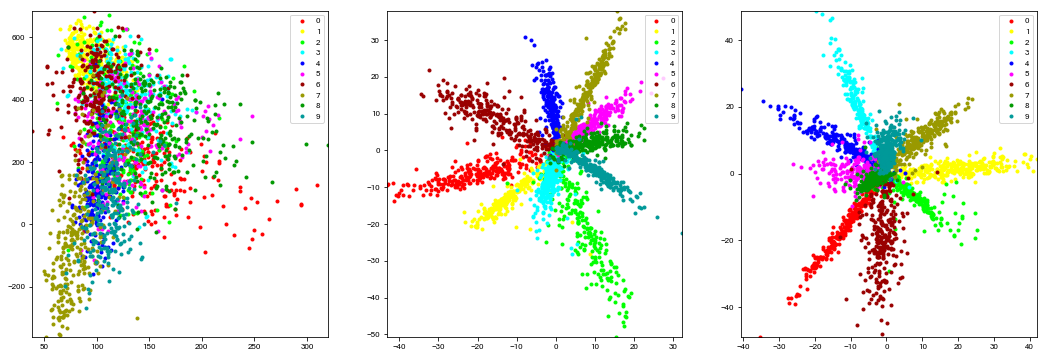

In [10]:

#plan.training_items[0].model[:4]
#plan.training_items[1].model[:11]


def centerloss_plot(plt,feat, labels,title=''):
    
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#009999']
    for i in range(10):
        plt.plot(feat[labels == i, 0], feat[labels == i, 1], '.', c=c[i])
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc = 'upper right')
    plt.xlim(left=feat[:,0].min(),right=feat[:, 0].max())
    plt.ylim(bottom=feat[:,1].min(),top=feat[:, 1].max())
    plt.title(title)
    
    
    
fig = plt.figure(figsize=(18,6)) 
plt.clf()
plt.ion()  # is not None:
for k in [1,2,3]:
    plt.subplot(1, 3, k)
    feats_result=[]
    label_result=[]
    
    for i,(data,label) in enumerate(data_provider):
        data=to_tensor(data)
        _=plan.training_items[k-1].model(data)
        feats=plan.training_items[k-1].model[-3].output
        feats=to_numpy(feats)
        feats_result.append(feats)
        label_result.append(label)  
        if i==20:
            break

    feats_result=np.concatenate(feats_result,axis=0)
    label_result=np.concatenate(label_result,axis=0)
    plt.title('model {0}'.format(i))
    centerloss_plot(plt,feats_result,label_result)
plt.ioff() 
display.display(plt.gcf())
plt.close(fig)

剛才的圖表代表甚麼意思呢? 這個圖表是來自於center loss的概念，他提醒了一個我們常常忘記了的關鍵「決策邊界」，也就是機器在做最後判斷時的分界，softmax雖然效果很好，但是他的決策邊界圖示像花朵一樣，越靠近中心點的位置，其實就是預測會錯誤的地方，當然center loss就是在解決這個問題，把這個觀念放到我們剛剛從mnist學習的三個模型來看，你會發現在最左邊基線模型其實決策邊界是混淆不堪的，有加了batch normalization(中間)很明顯決策邊界會清晰很多，加了dropout後，決策邊界又變得更銳利，從這邊就可以看的出來這幾個機制的效用。雖然基線模型在訓練時看起來準確度都不算差，但是較模糊的決策邊界意味著將很難通用。

![Alt text](../images/center_loss.jpg)

接下來的步驟是取出三個模型的梯度變化歷程，都只看第一層(形狀為(28\*28,64))，我們透過計算平均值消除掉axis=1，這樣形狀會變回28\*28，然後把它reshape成正方形，我們就可以看到對應圖像空間的梯度變化。

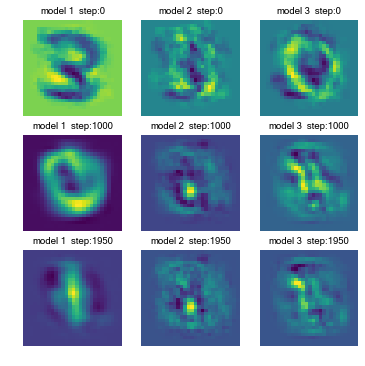

In [11]:
grad_dict={}

for i in  range(3):
    grad_dict[i]=[]
    for j in range(len(plan.training_items[i].gradients_history)):
        grad_dict[i].append(to_numpy(plan.training_items[i].gradients_history[j].value_list[0].copy()).mean(0))
        
fig =plt.figure(figsize=(6,6))
plt.clf()
plt.ion()  
for j in range(3):
    for i in [1,2,3]:
        plt.subplot(3,3, 3*j+i)
        n=[0,len(grad_dict[i-1])//2,len(grad_dict[i-1])-1][j]
        grad_grid=grad_dict[i-1][n].reshape([28,28])
        plt.pcolor(grad_grid)
        plt.title('model {0}  step:{1}'.format(i,n*50))
        plt.axis("off")
plt.ioff() 
display.display(fig)
plt.close(fig)